In [9]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [11]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [12]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'Kaggle_Computer_Vision/archive/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    'Kaggle_Computer_Vision/archive/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [13]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model(
    'Kaggle_Computer_Vision/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.save("Kaggle_Computer_Vision/savings")  # Use model.save()
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

INFO:tensorflow:Assets written to: Kaggle_Computer_Vision/savings\assets


INFO:tensorflow:Assets written to: Kaggle_Computer_Vision/savings\assets


In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
)

Epoch 1/30


80/80 [==============================] - 141s 2s/step - loss: 0.5429 - binary_accuracy: 0.7139 - val_loss: 0.4122 - val_binary_accuracy: 0.8293
Epoch 2/30
80/80 [==============================] - 108s 1s/step - loss: 0.3922 - binary_accuracy: 0.8272 - val_loss: 0.3636 - val_binary_accuracy: 0.8476
Epoch 3/30
80/80 [==============================] - 110s 1s/step - loss: 0.3451 - binary_accuracy: 0.8597 - val_loss: 0.3382 - val_binary_accuracy: 0.8577
Epoch 4/30
80/80 [==============================] - 114s 1s/step - loss: 0.3162 - binary_accuracy: 0.8736 - val_loss: 0.3234 - val_binary_accuracy: 0.8644
Epoch 5/30
80/80 [==============================] - 109s 1s/step - loss: 0.2885 - binary_accuracy: 0.8837 - val_loss: 0.3156 - val_binary_accuracy: 0.8687
Epoch 6/30
80/80 [==============================] - 111s 1s/step - loss: 0.2698 - binary_accuracy: 0.8939 - val_loss: 0.3106 - val_binary_accuracy: 0.8693
Epoch 7/30
80/80 [==============================] - 123s 2s/step - loss: 0.2479 -

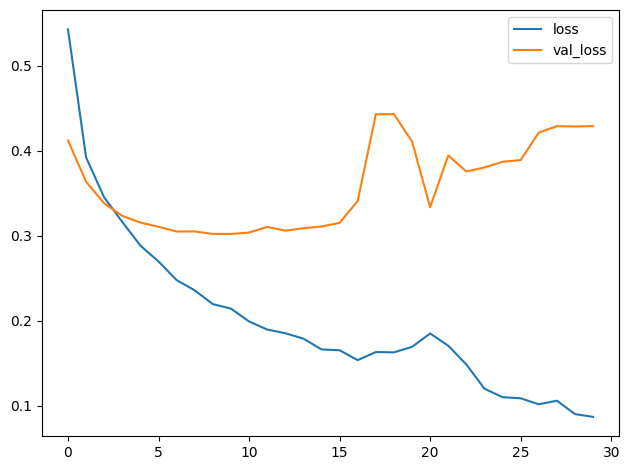

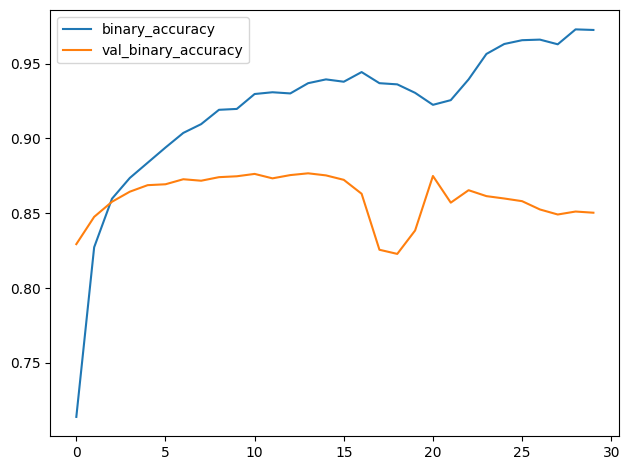

In [16]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();